<a href="https://colab.research.google.com/github/ParvG2005/Parv/blob/main/stock1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance nltk requests beautifulsoup4 tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Define stock ticker and date range
ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2023-12-31"

# Fetch data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Display first 5 rows
print(stock_data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.320436  24.789806  23.879985  24.778683  212818400
2015-01-05  23.635290  24.169170  23.448433  24.089088  257142000
2015-01-06  23.637518  23.897784  23.274924  23.699804  263188400
2015-01-07  23.968966  24.069067  23.735393  23.846617  160423600
2015-01-08  24.889902  24.947740  24.180287  24.298187  237458000


In [ ]:
# Calculate moving averages
stock_data['MA_5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['MA_20'] = stock_data['Close'].rolling(window=20).mean()

# Calculate daily returns
stock_data['Daily_Return'] = stock_data['Close'].pct_change()

# Calculate volatility (20-day rolling std)
stock_data['Volatility'] = stock_data['Daily_Return'].rolling(window=20).std()

# Drop missing values
stock_data.dropna(inplace=True)

# Display processed data
print(stock_data.head())

Price           Close       High        Low       Open     Volume       MA_5  \
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL              
Date                                                                           
2015-02-02  26.389217  26.509340  25.821971  26.260198  250956400  25.765910   
2015-02-03  26.393671  26.491548  26.162323  26.360303  207662800  26.189011   
2015-02-04  26.596092  26.807421  26.318030  26.360296  280598800  26.378094   
2015-02-05  26.785917  26.850683  26.631821  26.803782  168984800  26.445422   
2015-02-06  26.560360  26.855152  26.453162  26.803786  174826400  26.545052   

Price           MA_20 Daily_Return Volatility  
Ticker                                         
Date                                           
2015-02-02  24.715614     0.012547   0.023813  
2015-02-03  24.853533     0.000169   0.022587  
2015-02-04  25.001461     0.007669   0.022551  
2015-02-05  25.142309     0.007137   0.022477  
2015-02-06  25.225832  

In [ ]:
from bs4 import BeautifulSoup
import requests

def get_financial_news_sentiment(query="AAPL"):
    url = f"https://www.google.com/search?q={query}+stock+news&tbm=nws"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    headlines = []
    for headline in soup.find_all('div', class_='BNeawe vvjwJb AP7Wnd'):
        headlines.append(headline.get_text())

    # Sentiment analysis
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = [sia.polarity_scores(text)['compound'] for text in headlines]
    avg_sentiment = np.mean(sentiment_scores)

    return avg_sentiment

# Example usage
sentiment_score = get_financial_news_sentiment("AAPL")
print(f"Average sentiment score: {sentiment_score}")

Average sentiment score: 0.0089


In [ ]:
# Select features
features = ['Close', 'MA_5', 'MA_20', 'Volatility']
data = stock_data[features].values

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(scaled_data[:5])

[[0.03242317 0.02702004 0.01884914 0.30065312]
 [0.03244844 0.02943664 0.01965254 0.28125264]
 [0.03359691 0.03051661 0.02051425 0.28067053]
 [0.03467391 0.03090116 0.02133471 0.27949924]
 [0.03339417 0.03147021 0.02182125 0.26103164]]


In [ ]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), :])
        y.append(data[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(y)

# Split into train (80%) and test (20%)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (1734, 60, 4)
Testing data shape: (388, 60, 4)


In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,451 (200.98 KB)

 Trainable params: 51,451 (200.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.0167 - val_loss: 0.0016
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0011 - val_loss: 0.0060
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 9.7143e-04 - val_loss: 0.0013
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 8.5147e-04 - val_loss: 0.0012
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - loss: 7.5667e-04 - val_loss: 0.0056
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 7.4469e-04 - val_loss: 0.0040
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 80

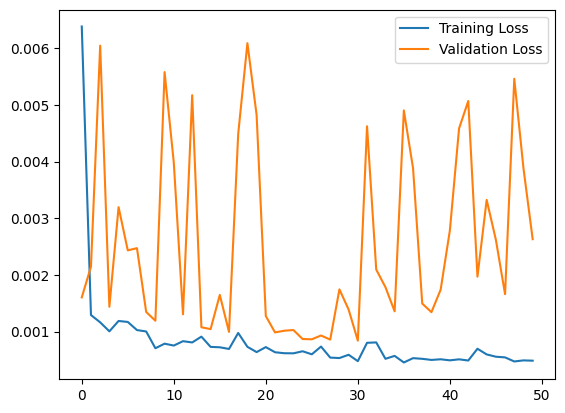

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step


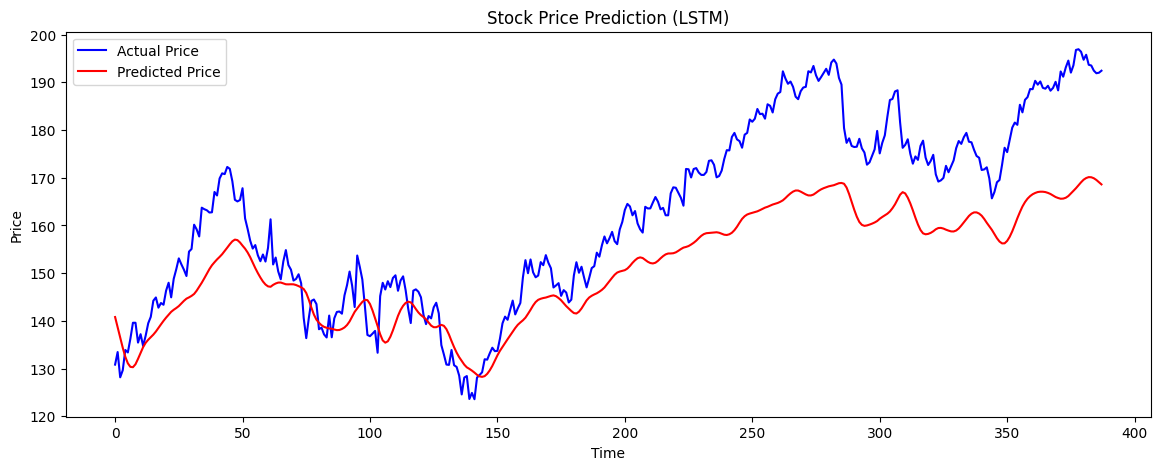

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)

# Inverse scaling to get actual prices
y_pred_actual = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((len(y_pred), 3))], axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1,1), np.zeros((len(y_test), 3))], axis=1))[:, 0]

# Plot predictions vs actual
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(y_pred_actual, label='Predicted Price', color='red')
plt.title('Stock Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Wrong (from error message):
print(f"Root Mean Squared Error (RMSE): (rmse:.2f)")

# Correct:
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): (rmse:.2f)
Root Mean Squared Error (RMSE): 13.76


In [ ]:
model.save("stock_price_lstm.h5")